In [1]:
import pandas as pd
import numpy as np
from darts import TimeSeries
from darts.models import TransformerModel
from darts.metrics import mse, rmse, r2_score, mae, smape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank
)
import json
import shap
from numpy.lib.stride_tricks import sliding_window_view
from darts.explainability.explainability_result import ComponentBasedExplainabilityResult

In [2]:
result_path = 'results/Transformer/'

In [3]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity', 'Wind_Speed_kmh',
    'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos'
]

df = pd.read_csv("data/ground_station_clean.csv")

In [4]:
encoders = {
    "cyclic":{
        "past":["month","dayofyear","day","hour","minute"],
        "future":["month","dayofyear","day","hour","minute"],
    },
    "transformer": Scaler()
}

In [5]:
best_r2 = float('-inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_forecasts = None
# Define model parameters

# Set up time series cross-validation with 5 folds, respecting temporal order of data
tscv = TimeSeriesSplit(n_splits=5)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTraining the model...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")

    scaler = Scaler()
    # Fit the scaler only on training data to avoid data leakage
    scaler = scaler.fit(train_fold)
    # Transform all time series
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)


    model = TransformerModel(
        model_name=f"model_{fold+1}",
        input_chunk_length=57,
        output_chunk_length=1,
        n_epochs=30,
        batch_size=24,
        d_model=128,
        num_encoder_layers=1,
        num_decoder_layers=3,
        activation="GLU",
        dropout=0.077033257895267065,
        add_encoders=encoders,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.HuberLoss(),
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode":"min", "factor":0.5, "patience":4, "min_lr":1e-6},
        save_checkpoints=True,
        show_warnings=True,
        force_reset=True, # Importante para que cada iteração treine do zero com este model_name
        optimizer_kwargs={"lr":0.0012200442601871598 , "weight_decay": 1e-5},
    )
    model.fit(
        series=[train_scaled],
        val_series=val_scaled,
        dataloader_kwargs={"num_workers": 11}
    )

    model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{fold+1}/", best=True)

    # Generate historical forecasts to evaluate model performance on past data
    forecasts = model.historical_forecasts(
        train_scaled,
        start=0.8,
        forecast_horizon=1,
        stride=1,
        retrain=False,
        last_points_only=True,
    )


    forecasts_t = scaler.inverse_transform(forecasts)
    s = scaler.inverse_transform(train_scaled).split_after(0.8)[1]

    r2_geral = r2_score(s, forecasts_t)
    print(f"O R2 desse fold foi {r2_geral}")
    if best_r2 < r2_geral:
        best_r2 = r2_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold foi {best_fold}")



Fold 1

Training the model...
Train set: 1389 samples
Validation set: 1384 samples


Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('AMD Radeon RX 6700 XT') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 6.365


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.001. New best score: 6.344


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 6.334


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 6.324


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 6.324. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
Specified future encoders in `add_encoders` at mod

O R2 desse fold foi -5.581276603219612

Fold 2

Training the model...
Train set: 2773 samples
Validation set: 1384 samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.059


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.036 >= min_delta = 0.001. New best score: 0.022


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.016


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.014


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.012


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.010


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.007


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.004. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
Specified future encoders in `add_encoders` at mod

O R2 desse fold foi 0.8158164780272493

Fold 3

Training the model...
Train set: 4157 samples
Validation set: 1384 samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.008


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.002. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Networ

O R2 desse fold foi -inf

Fold 4

Training the model...
Train set: 5541 samples
Validation set: 1384 samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.019


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.017


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.016


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.012


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.012. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Networ

O R2 desse fold foi -inf

Fold 5

Training the model...
Train set: 6925 samples
Validation set: 1384 samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.019


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.015


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.012


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.011


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.011. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


O R2 desse fold foi -33.890743531783464
O melhor fold foi 2


In [9]:
model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{best_fold}/", best=True)

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)


TransformerModel(output_chunk_shift=0, d_model=128, nhead=4, num_encoder_layers=1, num_decoder_layers=3, dim_feedforward=512, dropout=0.07703325789526706, activation=GLU, norm_type=None, custom_encoder=None, custom_decoder=None, model_name=model_2, input_chunk_length=57, output_chunk_length=1, n_epochs=30, batch_size=24, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute'], 'future': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler}, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7fea4698d130>]}, loss_fn=HuberLoss(), lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'factor': 0.5, 'patience': 4, 'min_lr': 1e-06}, save_checkpoints=True, show_warnings=True, force_reset=True, optimizer_kwargs={'lr': 0.0012200442601871598, 'weight_decay': 1e-05})

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting time series verification for consistency...

Performance metrics:
                                    MSE        RMSE         MAE        R2  \
Temperature                    4.992318    2.234350    1.490075  0.889441   
Precipitation_accumulated    208.396900   14.435959    9.751264  0.994983   
Humidity                      19.300350    4.393216    3.283268  0.898268   
Wind_Speed_kmh                 0.070914    0.266297    0.188038  0.765920   
Soil_Moisture              45327.192248  212.901837  128.670855  0.965483   
Soil_Temperature               8.339185    2.887765    1.924916  0.819114   
Wind_Dir_Sin                   0.075997    0.275675    0.183370  0.778045   
Wind_Dir_Cos                   0.124398    0.352702    0.219082  0.803871   

                                SMAPE  
Temperature                 10.013917  
Precipitation_accumulated   18.013647  
Humidity                     4.218363  
Wind_Speed_kmh              91.408487  
Soil_Moisture                1.

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/Transformer//previsao_vs_real_1.png


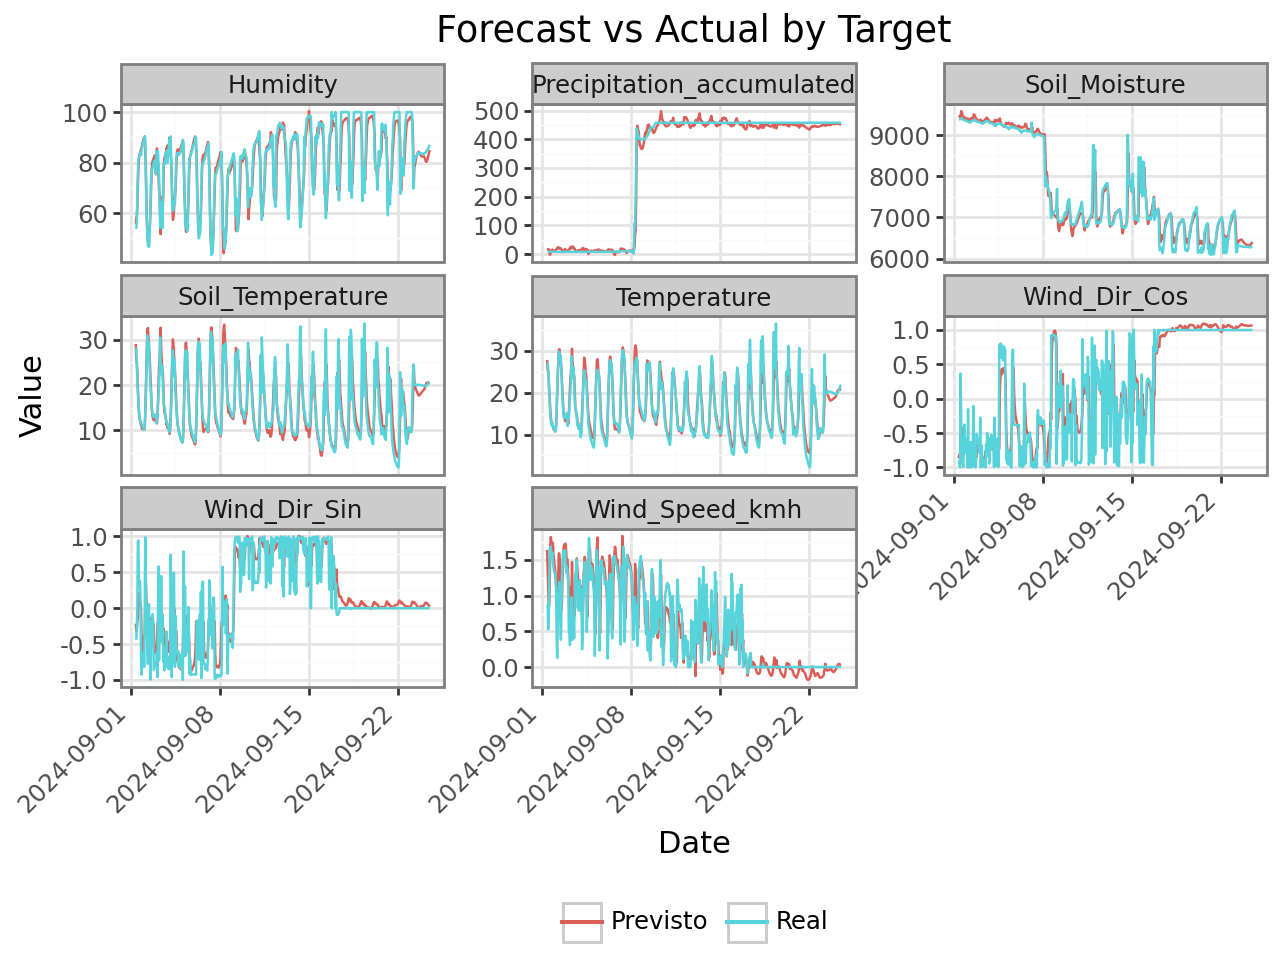

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting time series verification for consistency...

Performance metrics:
                                     MSE        RMSE         MAE        R2  \
Temperature                    14.383680    3.792582    2.859792  0.680296   
Precipitation_accumulated    1996.277248   44.679719   17.090165  0.951460   
Humidity                       70.701128    8.408396    6.820210  0.624322   
Wind_Speed_kmh                  0.268660    0.518324    0.371210  0.116938   
Soil_Moisture              208984.456584  457.148178  344.448121  0.839143   
Soil_Temperature               17.810377    4.220234    3.214704  0.612339   
Wind_Dir_Sin                    0.108330    0.329135    0.231300  0.684094   
Wind_Dir_Cos                    0.229683    0.479253    0.321964  0.636909   

                                SMAPE  
Temperature                 19.183520  
Precipitation_accumulated   19.305242  
Humidity                     8.640536  
Wind_Speed_kmh             116.383526  
Soil_Moisture         

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/Transformer//previsao_vs_real_6.png


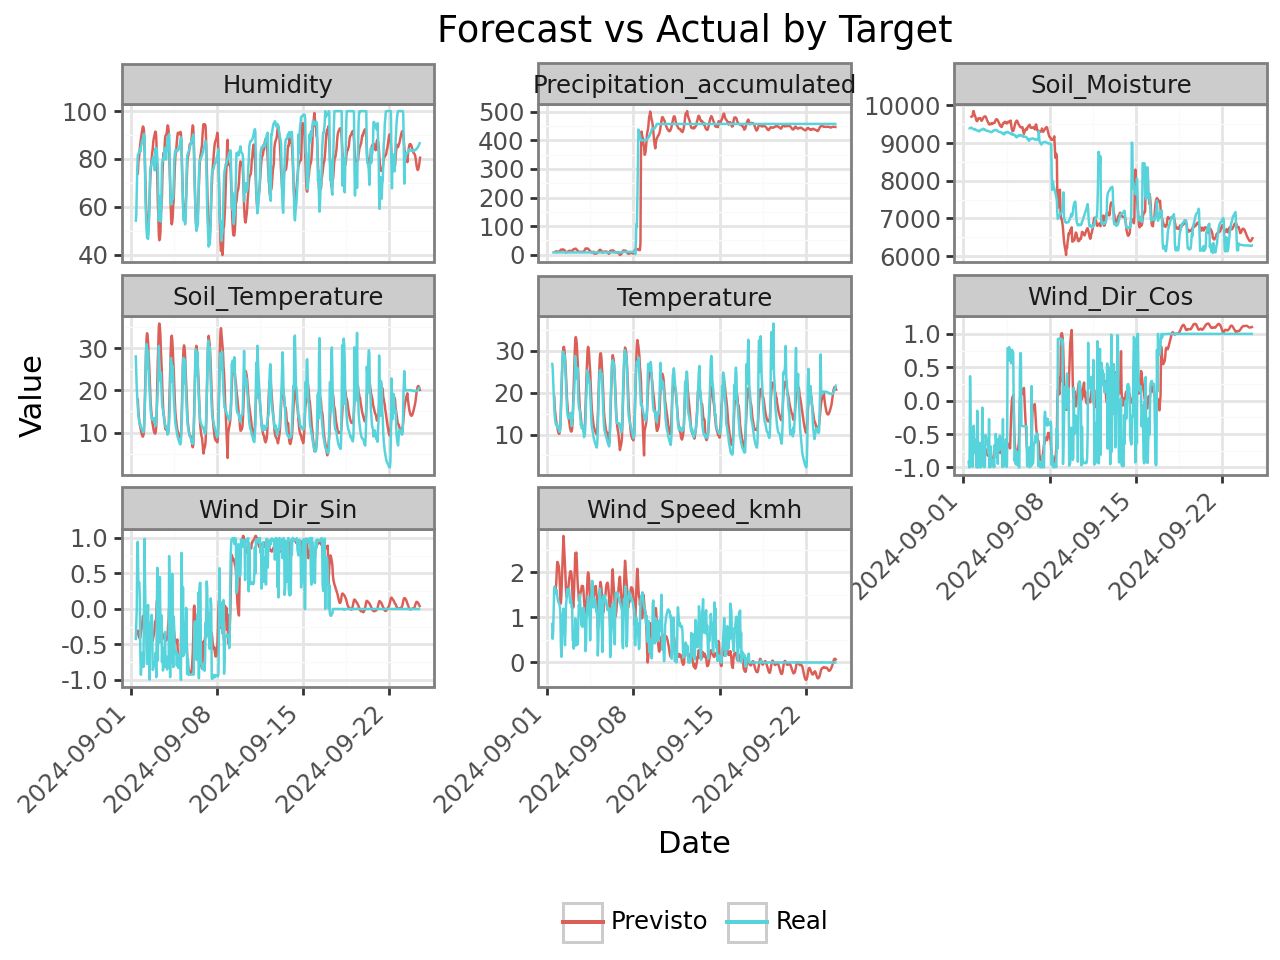

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting time series verification for consistency...

Performance metrics:
                                     MSE        RMSE         MAE        R2  \
Temperature                    17.277282    4.156595    3.156847  0.619325   
Precipitation_accumulated    3747.662236   61.218153   21.128691  0.907413   
Humidity                      102.599752   10.129154    8.354270  0.460684   
Wind_Speed_kmh                  0.380531    0.616872    0.434221 -0.286763   
Soil_Moisture              357505.764808  597.917858  463.040334  0.720054   
Soil_Temperature               20.251565    4.500174    3.447491  0.563330   
Wind_Dir_Sin                    0.114220    0.337965    0.236850  0.667876   
Wind_Dir_Cos                    0.324277    0.569453    0.378368  0.485009   

                                SMAPE  
Temperature                 21.485439  
Precipitation_accumulated   19.489234  
Humidity                    10.537314  
Wind_Speed_kmh             126.116368  
Soil_Moisture         

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/Transformer//previsao_vs_real_12.png


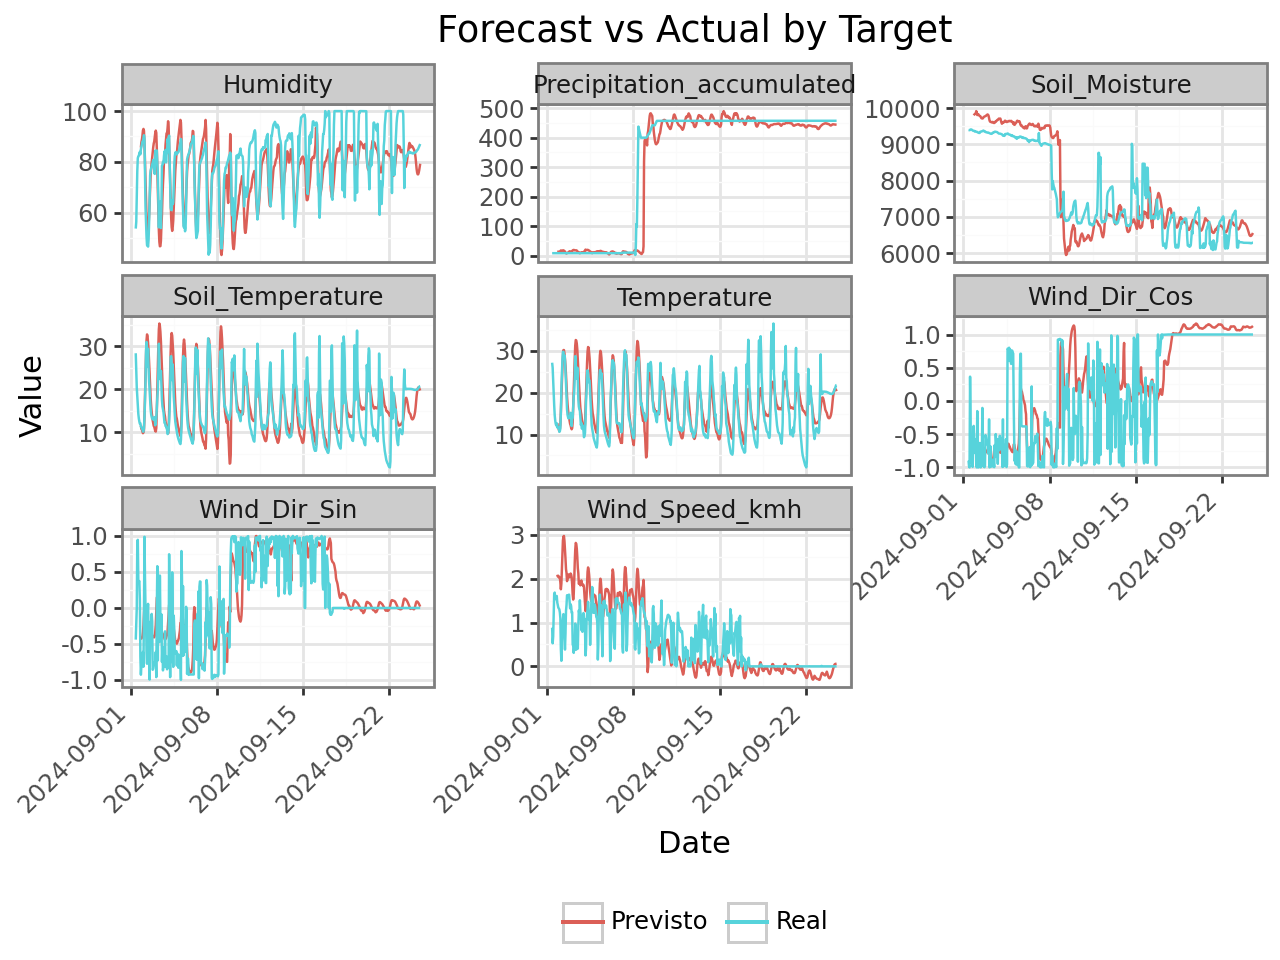

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting time series verification for consistency...

Performance metrics:
                                     MSE        RMSE         MAE        R2  \
Temperature                    18.441481    4.294355    3.292489  0.593125   
Precipitation_accumulated    7365.863088   85.824607   30.017542  0.811412   
Humidity                      124.778113   11.170412    9.168159  0.343576   
Wind_Speed_kmh                  0.541751    0.736037    0.528202 -0.845980   
Soil_Moisture              561394.626971  749.262722  581.181729  0.544736   
Soil_Temperature               22.137777    4.705080    3.666015  0.521180   
Wind_Dir_Sin                    0.135257    0.367773    0.262412  0.602385   
Wind_Dir_Cos                    0.435676    0.660057    0.455415  0.304370   

                                SMAPE  
Temperature                 22.020136  
Precipitation_accumulated   24.337576  
Humidity                    11.592069  
Wind_Speed_kmh             135.068337  
Soil_Moisture         

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/Transformer//previsao_vs_real_24.png


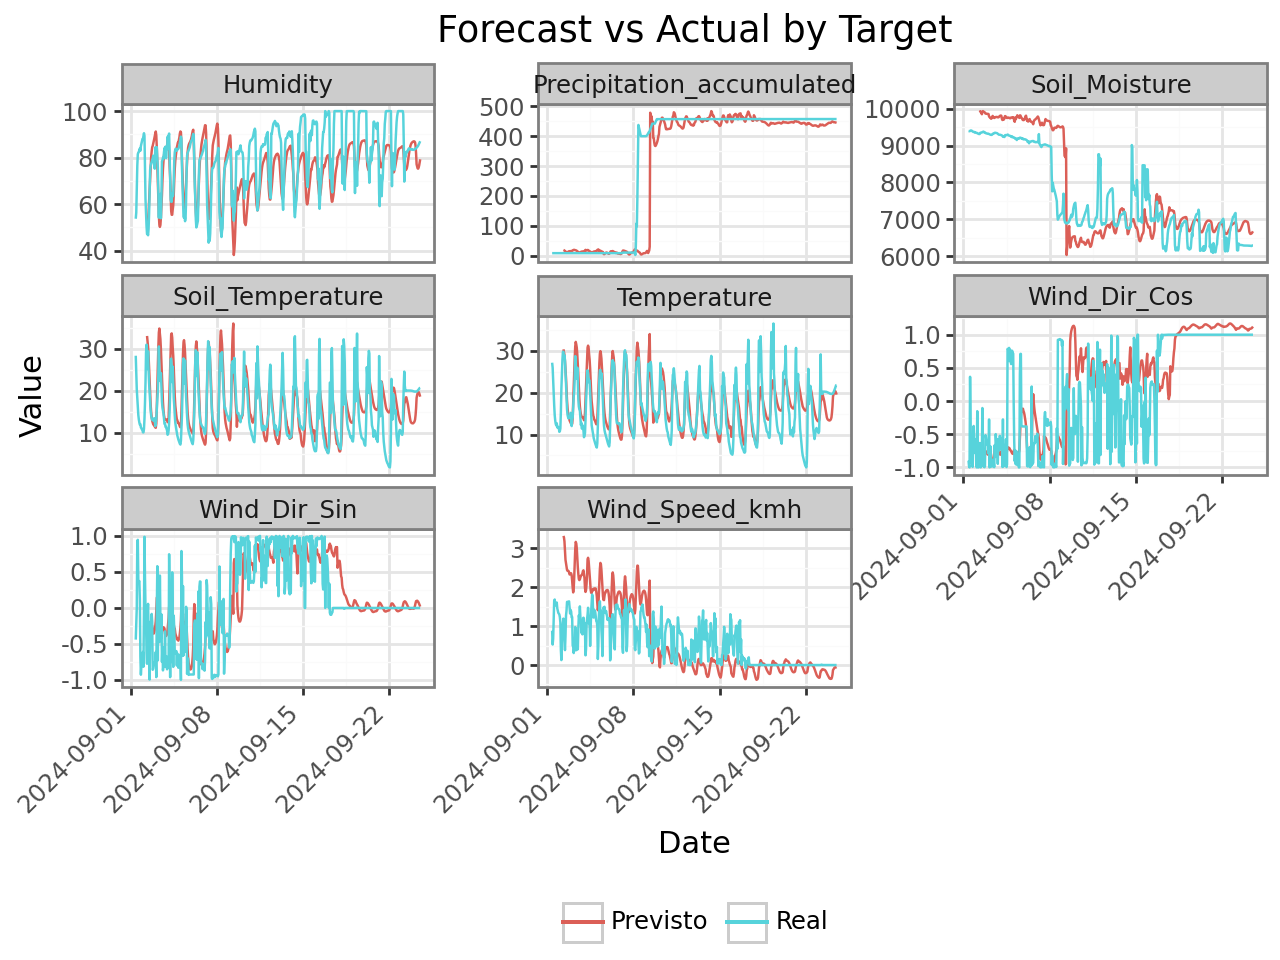

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting time series verification for consistency...

Performance metrics:
                                    MSE         RMSE         MAE        R2  \
Temperature                2.823509e+01     5.313671    4.215624  0.378396   
Precipitation_accumulated  1.661036e+04   128.881195   53.286738  0.534381   
Humidity                   1.442353e+02    12.009799    9.724481  0.222685   
Wind_Speed_kmh             1.227448e+00     1.107902    0.760374 -3.332053   
Soil_Moisture              1.042576e+06  1021.066051  749.595621  0.077289   
Soil_Temperature           3.120053e+01     5.585743    4.395822  0.327127   
Wind_Dir_Sin               2.172053e-01     0.466053    0.354516  0.347725   
Wind_Dir_Cos               6.511741e-01     0.806954    0.546433 -0.062436   

                                SMAPE  
Temperature                 27.631078  
Precipitation_accumulated   33.696177  
Humidity                    12.215795  
Wind_Speed_kmh             146.843661  
Soil_Moisture         

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/Transformer//previsao_vs_real_48.png


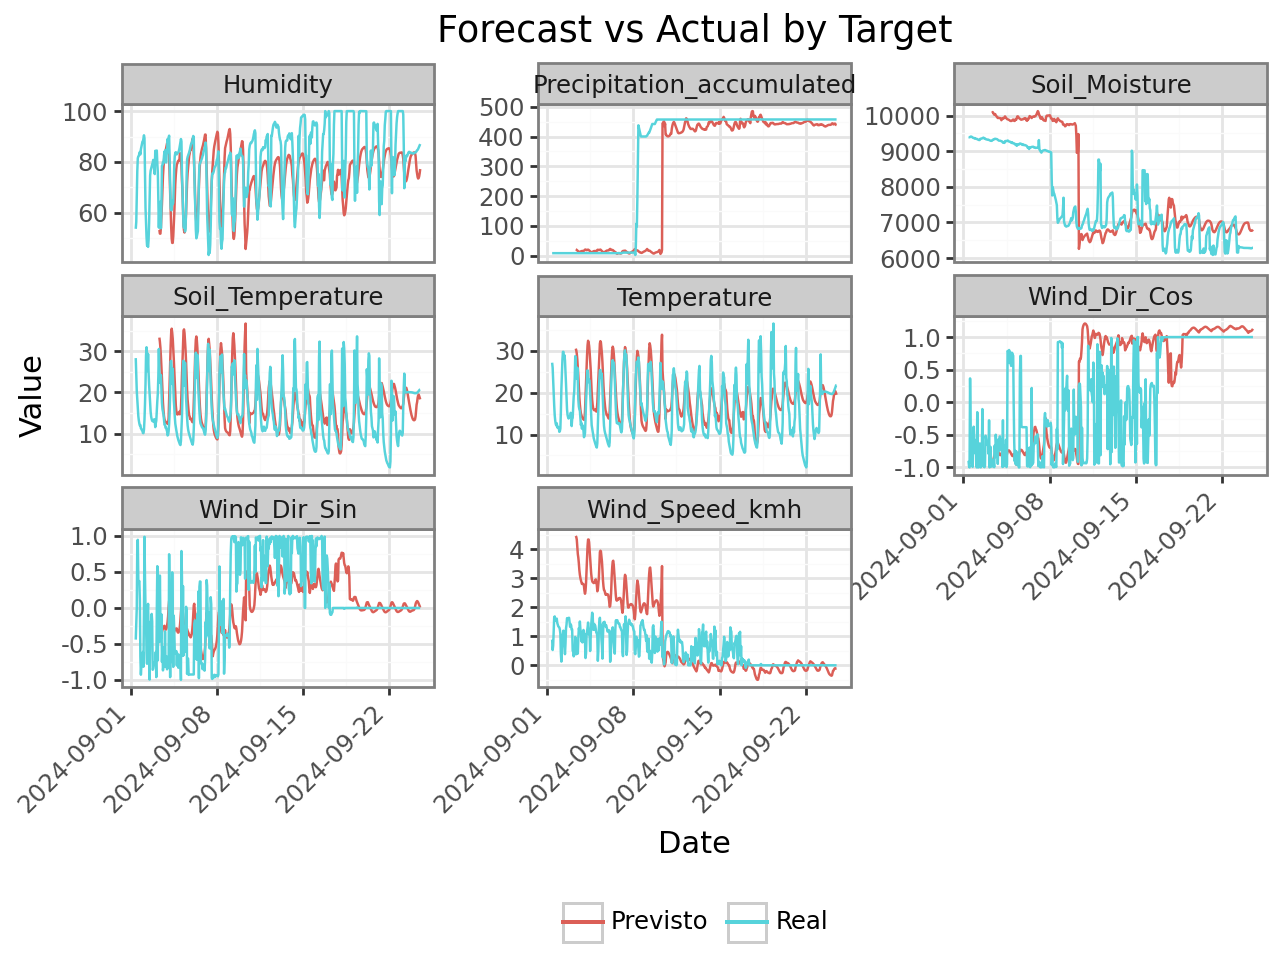

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting time series verification for consistency...

Performance metrics:
                                    MSE         RMSE         MAE        R2  \
Temperature                3.412893e+01     5.841997    4.816279  0.259752   
Precipitation_accumulated  2.698760e+04   164.279046   80.819971  0.140852   
Humidity                   1.569001e+02    12.525976   10.214546  0.164310   
Wind_Speed_kmh             2.159282e+00     1.469449    0.961320 -6.601541   
Soil_Moisture              1.625497e+06  1274.949745  896.826395 -0.616541   
Soil_Temperature           3.513417e+01     5.927408    4.899331  0.251570   
Wind_Dir_Sin               2.984518e-01     0.546307    0.412777  0.062489   
Wind_Dir_Cos               6.906194e-01     0.831035    0.556010 -0.152415   

                                SMAPE  
Temperature                 31.551285  
Precipitation_accumulated   45.527207  
Humidity                    12.752742  
Wind_Speed_kmh             150.789399  
Soil_Moisture         

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/Transformer//previsao_vs_real_72.png


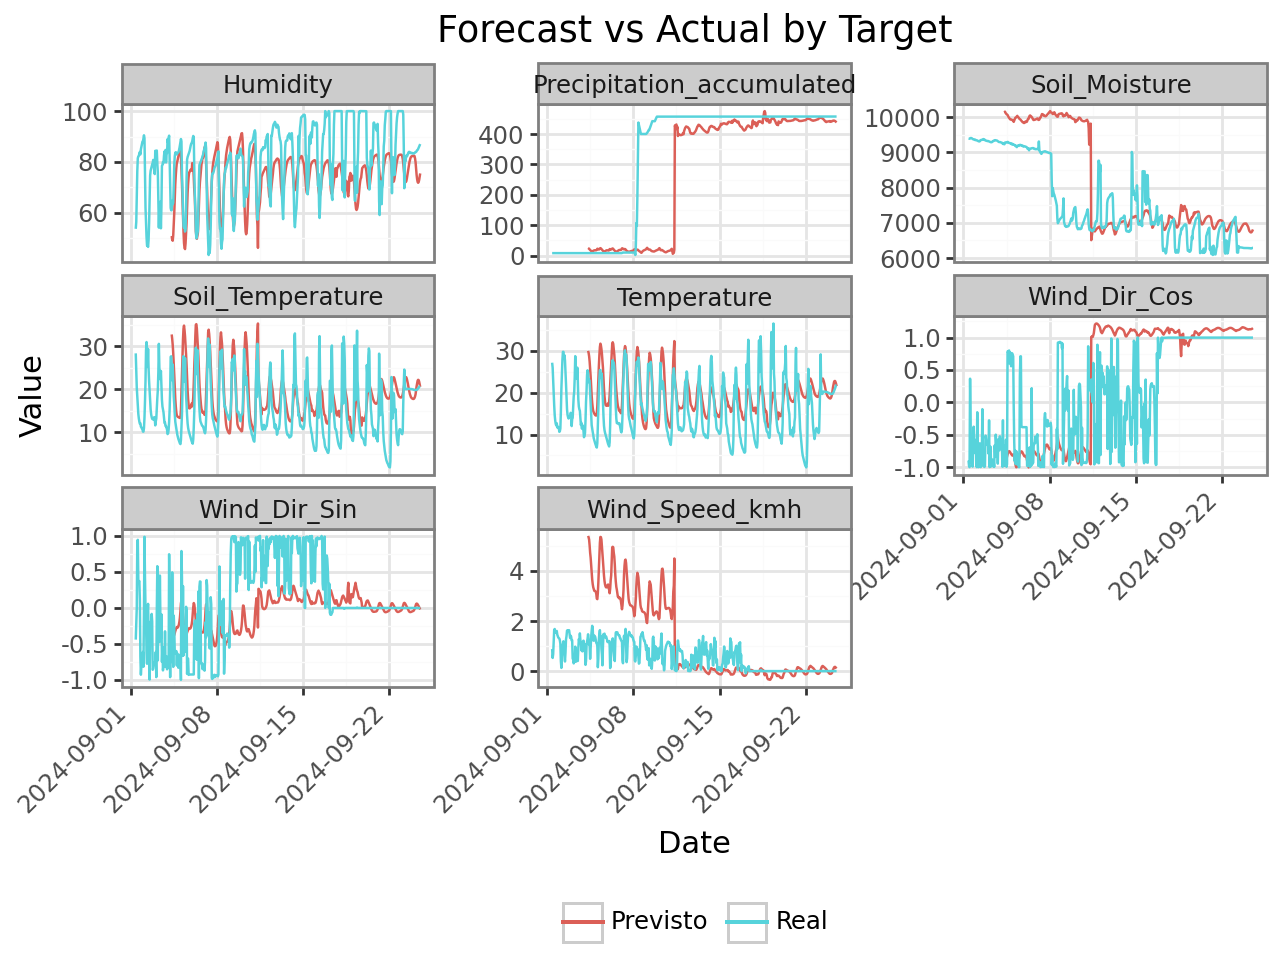

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting time series verification for consistency...

Performance metrics:
                                    MSE         RMSE          MAE          R2  \
Temperature                4.470345e+01     6.686064     5.145221    0.016099   
Precipitation_accumulated  7.913590e+04   281.311034   191.051110 -214.019869   
Humidity                   2.044467e+02    14.298486    12.294533   -0.238566   
Wind_Speed_kmh             5.849020e+00     2.418475     1.594639  -30.033212   
Soil_Moisture              3.562051e+06  1887.339792  1485.718693  -10.535217   
Soil_Temperature           4.638338e+01     6.810534     5.407532   -0.014164   
Wind_Dir_Sin               4.700943e-01     0.685634     0.484823   -1.367001   
Wind_Dir_Cos               5.840074e-01     0.764204     0.506343   -0.113592   

                                SMAPE  
Temperature                 32.794605  
Precipitation_accumulated   80.235994  
Humidity                    15.592697  
Wind_Speed_kmh             166.2882

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/Transformer//previsao_vs_real_168.png


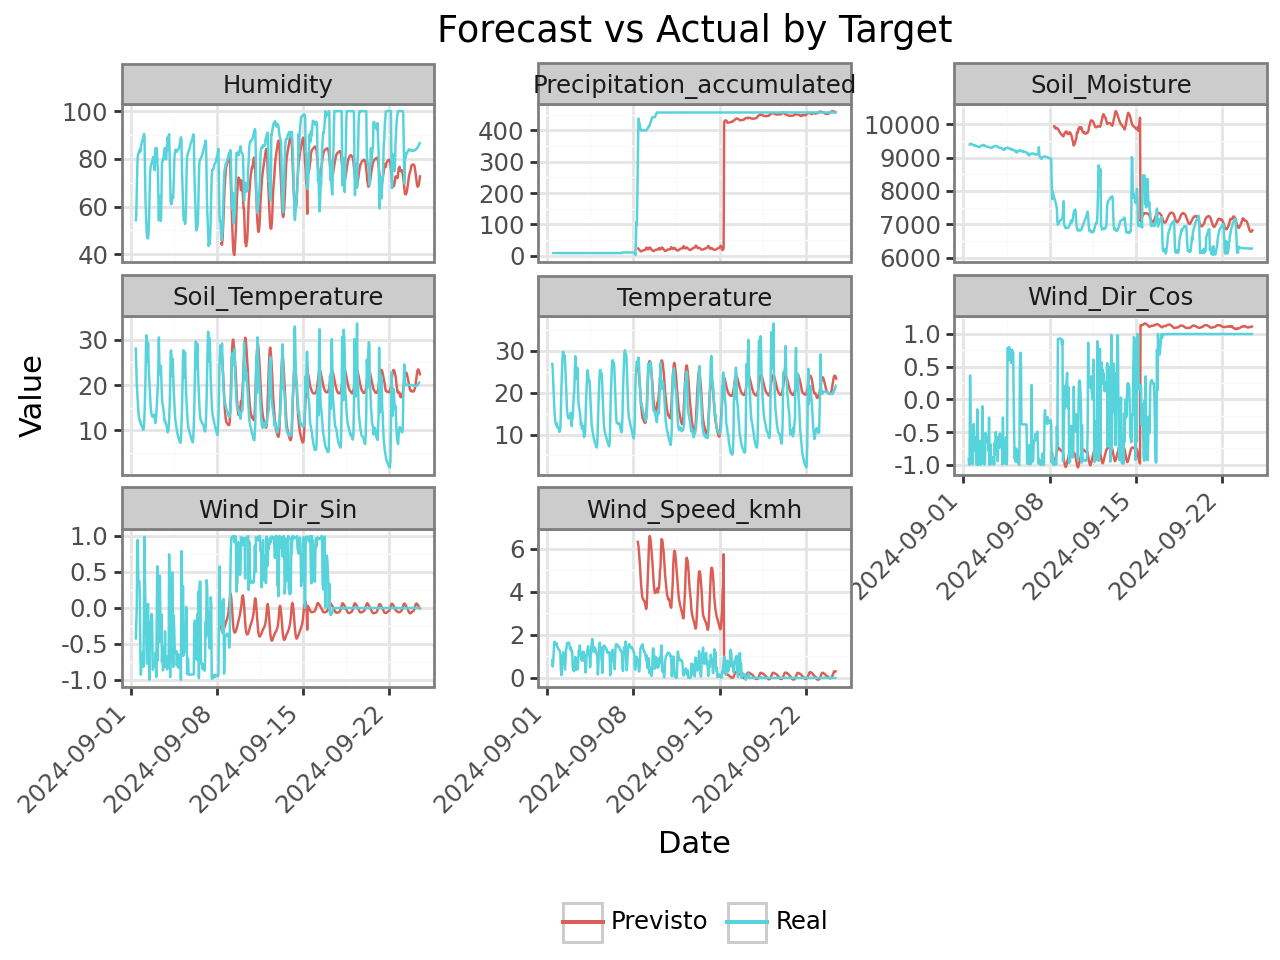

In [7]:
for forecast_horizon in [1,6,12,24,48,72,168]:
    forecasts = model.historical_forecasts(
        best_train_scaled,
        start=0.8,
        forecast_horizon=forecast_horizon,
        stride=1,
        retrain=False,
        last_points_only=True,
        predict_kwargs={"dataloader_kwargs":{"num_workers": 11}}
    )

    forecasts_t = best_scaler.inverse_transform(forecasts)
    s = best_scaler.inverse_transform(best_train_scaled).split_after(0.8)[1]
    metrics = {}
    print("Starting time series verification for consistency...")
    for target in target_columns:
        metrics[target] = {
            'MSE': mse(s[target], forecasts_t[target]),
            'RMSE': rmse(s[target], forecasts_t[target]),
            'MAE': mae(s[target], forecasts_t[target]),
            'R2': r2_score(s[target], forecasts_t[target]),
            'SMAPE': smape(s[target], forecasts_t[target]),
        }
    metrics_df = pd.DataFrame(metrics).T
    print("\nPerformance metrics:")
    print(metrics_df)

    s_df = s.to_dataframe()
    s_df = s_df.reset_index()
    forecasts_t_df = forecasts_t.to_dataframe()
    forecasts_t_df = forecasts_t_df.reset_index()
    forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})
    print(forecasts_t_df.columns)

    plot_columns = ['Timestamp'] + target_columns
    s_melted = s_df[plot_columns].melt(
        id_vars='Timestamp',
        var_name='target_column',
        value_name='value'
    )
    s_melted['type'] = 'Real'

    forecasts_t_melted = forecasts_t_df[plot_columns].melt(
        id_vars='Timestamp',
        var_name='target_column',
        value_name='value'
    )
    forecasts_t_melted['type'] = 'Previsto'

    # Concatena os DataFrames 'Real' e 'Previsto'
    df_combined = pd.concat([s_melted, forecasts_t_melted])

    # Opcional: Renomear a coluna de índice para algo mais descritivo, se for data/hora
    df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

    plot = (
            ggplot(df_combined, aes(x='Date', y='value', color='type'))
            + geom_line()
            + facet_wrap('~ target_column', scales='free_y') # Creates a subplot for each 'target_column'
            + labs(
        title='Forecast vs Actual by Target',
        x='Date',
        y='Value',
        color='Data Type' # Legend for color
    )
            + theme_bw()
            + theme(
        axis_text_x=element_text(rotation=45, hjust=1), # Rotates x-axis labels
        legend_position='bottom', # Places legend at the bottom
        legend_title=element_blank(), # Removes legend title
    )
    )

    plot.save(f'{result_path}/previsao_vs_real_{forecast_horizon}.png', width=12, height=10, dpi=300)
    plot.show()

    with open(f'{result_path}/metrics_{forecast_horizon}.json', 'w') as f:
        json.dump(metrics_df.to_dict(), f, indent=4)


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

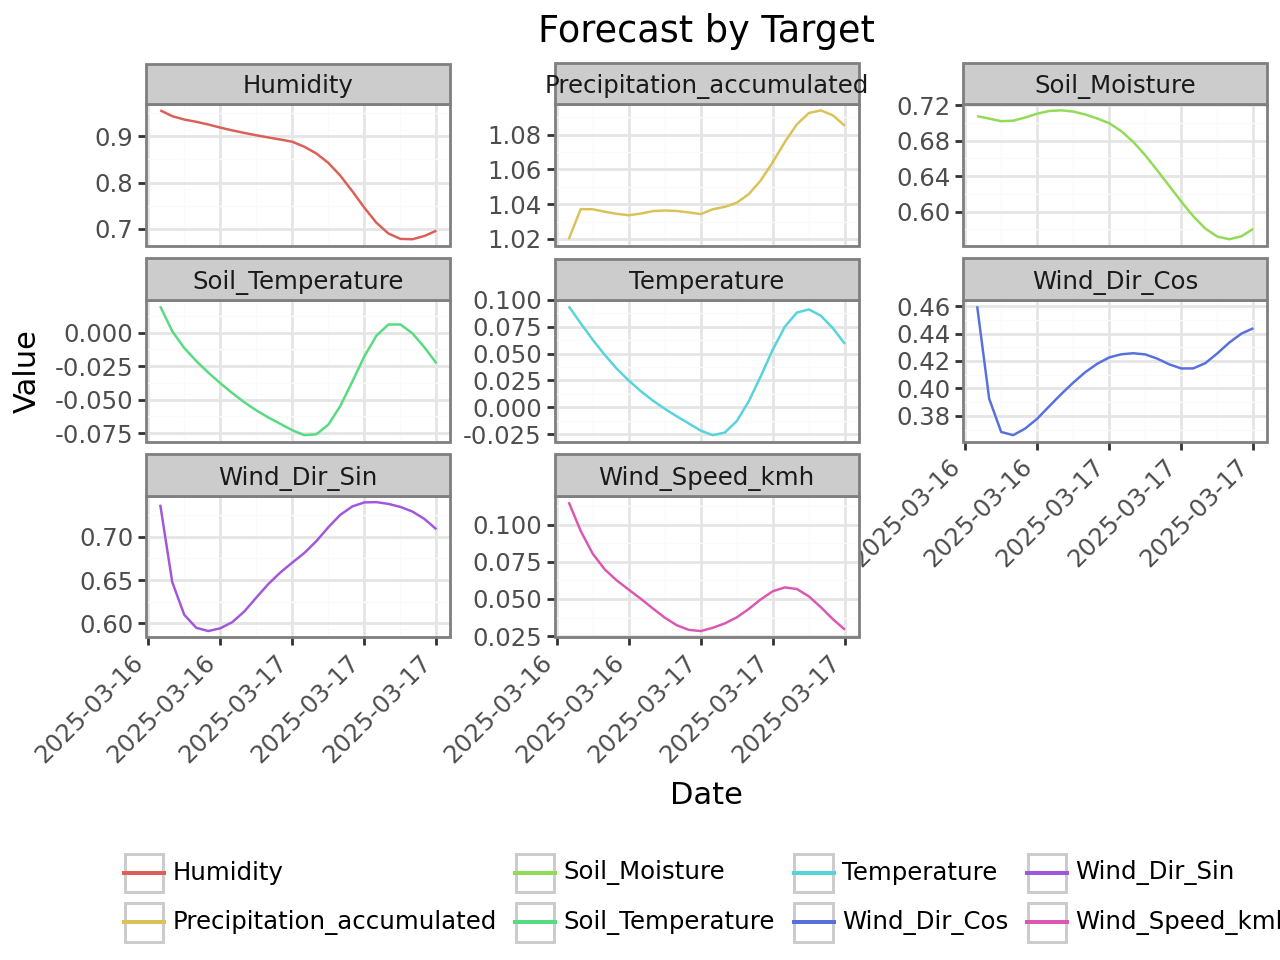

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/Transformer//pred_future_24.png


In [8]:
pred = model.predict(
    n=24,
    verbose=True
)

pred.t = best_scaler.inverse_transform(pred)
pred_df = pred.to_dataframe()
pred_df = pred_df.reset_index()
pred_df = pred_df.rename(columns={"time": "Timestamp"})

plot_columns = ['Timestamp'] + target_columns
pred_melted = pred_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)

plot = (
        ggplot(pred_melted, aes(x='Timestamp', y='value', color='target_column'))
        + geom_line()
        + facet_wrap('~ target_column', scales='free_y') # Creates a subplot for each 'target_column'
        + labs(
    title='Forecast by Target',
    x='Date',
    y='Value',
    color='Data Type' # Legend for color
)
        + theme_bw()
        + theme(
    axis_text_x=element_text(rotation=45, hjust=1), # Rotates x-axis labels
    legend_position='bottom', # Places legend at the bottom
    legend_title=element_blank(), # Removes legend title

)
)
plot.show()
plot.save(f'{result_path}/pred_future_24.png', width=12, height=10, dpi=300)
